# Transfer Learning with TensorFlow, Fine-Tuning

In [1]:
# Check for GPU 
!nvidia-smi

Wed Aug 31 19:48:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrithe them all. This is tedious though.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks.

In [2]:
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py

--2022-08-31 19:48:21--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  10.00K  --.-KB/s    in 0s      

2022-08-31 19:48:21 (101 MB/s) - ‘helper.py’ saved [10235/10235]



In [3]:
# Import helper functions we are going to use in this notebook
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

Using the pretrained models within `tf.keras.applications`

[link here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [4]:
# Get 10% of trainig data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-31 19:48:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   224MB/s    in 0.7s    

2022-08-31 19:48:25 (224 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf

# Using image data from directory, all in one hit, no need for image_datagen instance
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Means that the labels are encoded as a categorical vector (for `categorical_crossentropy` loss), for multiclass data 
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# tf have turned the data into batches(BatchDataset)
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

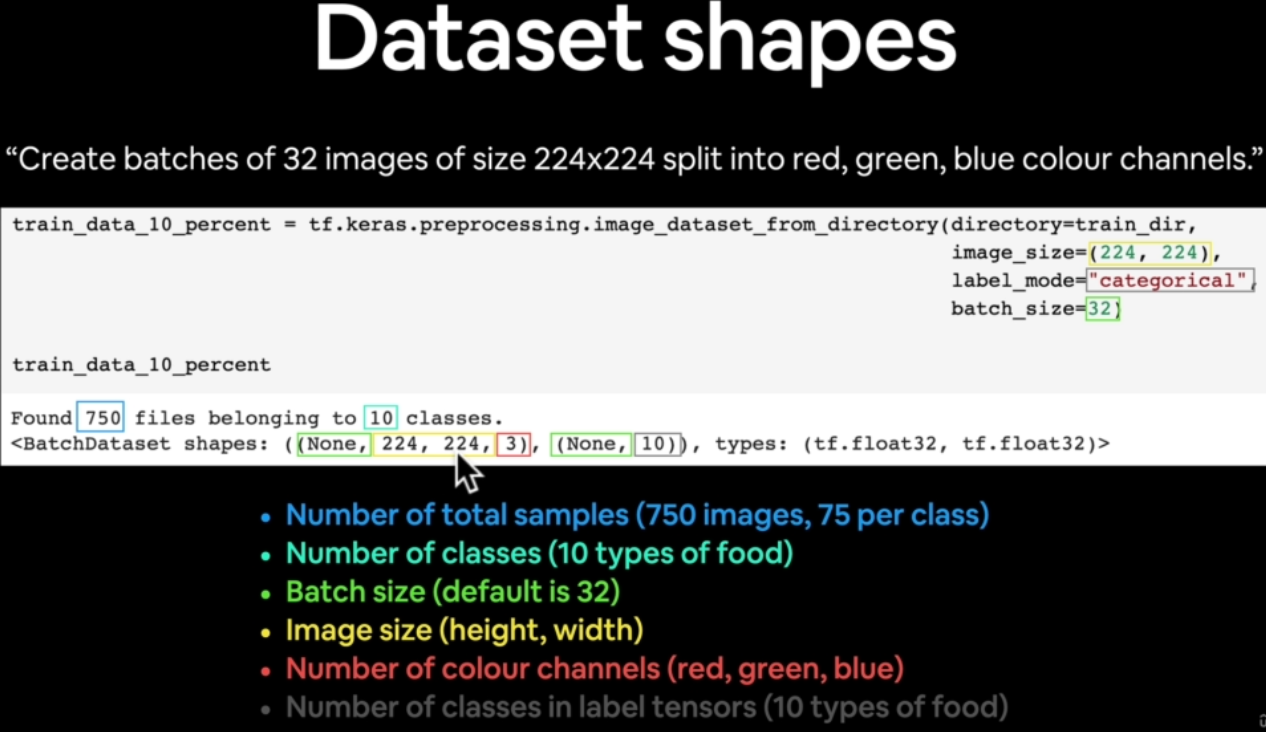

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[8.57448959e+01 5.07448959e+01 3.07448978e+01]
   [8.72806091e+01 5.02806129e+01 3.22806129e+01]
   [8.82908096e+01 5.15051003e+01 3.39336739e+01]
   ...
   [1.93571533e+02 1.90000061e+02 2.06143005e+02]
   [1.95285767e+02 1.90285767e+02 2.10285767e+02]
   [2.03357147e+02 1.95357147e+02 2.16357147e+02]]

  [[8.25204010e+01 4.95204086e+01 3.05204086e+01]
   [8.12193832e+01 4.62193871e+01 2.72193871e+01]
   [8.21275558e+01 4.69132652e+01 2.85561218e+01]
   ...
   [1.86944031e+02 1.83372559e+02 1.99714462e+02]
   [1.95357178e+02 1.87357178e+02 2.08357178e+02]
   [2.01734756e+02 1.93734756e+02 2.14734756e+02]]

  [[7.55663223e+01 4.47142868e+01 2.81377544e+01]
   [7.72397995e+01 4.46122437e+01 2.79693890e+01]
   [7.61224518e+01 4.35510216e+01 2.63367348e+01]
   ...
   [1.73760330e+02 1.70188858e+02 1.86546066e+02]
   [1.86627594e+02 1.78627594e+02 1.99627594e+02]
   [1.99576752e+02 1.90576752e+02 2.11576752e+02]]

  ...

  [[1.87923416e+02 1.77923416e+02 1.52923416e+02]
   [1

In [11]:
# Creating a model

ResNet152 = tf.keras.applications.resnet.ResNet152(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   classes=10)

234708992/234698864 [==============================] - 1s 0us/step


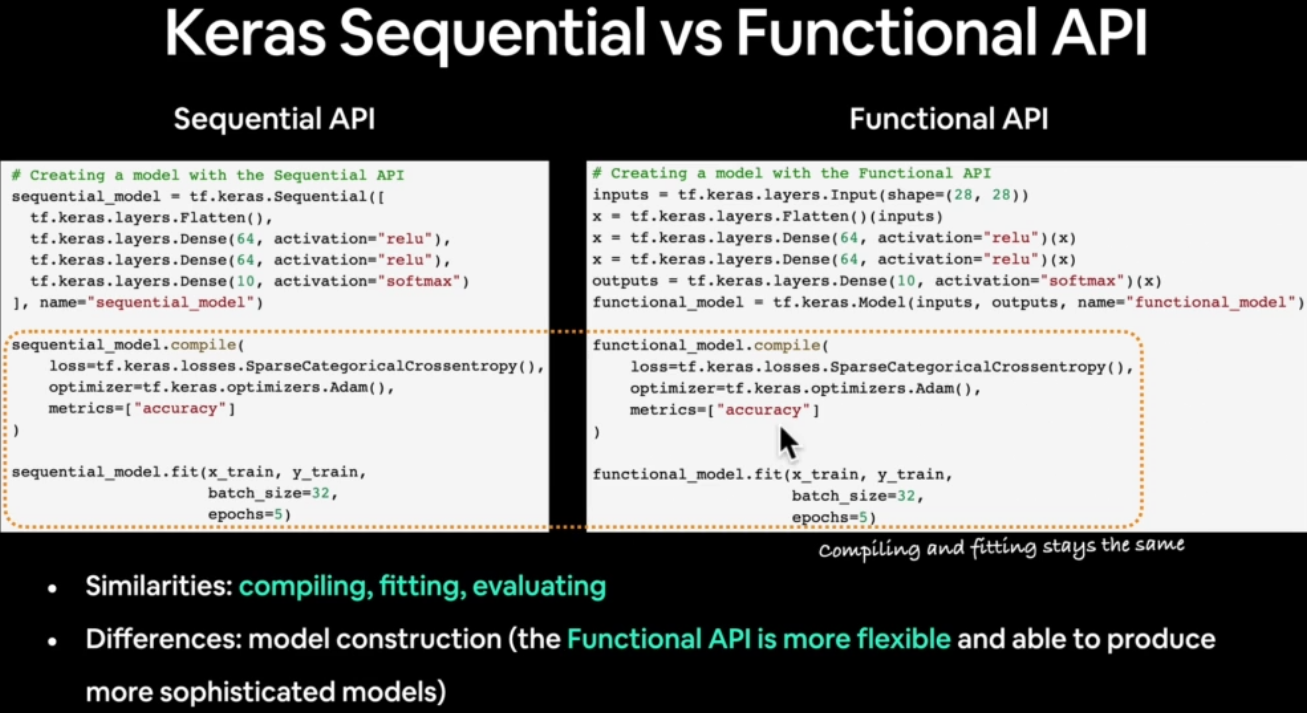

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequentinal API is straight-forward, it runs our layers in sequntial order.

But the functional API gives us more flexibility with our models

In [12]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False,)

# 2. Freeze the base model (so the underlaying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs 
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Avarage pool the outputs of the base model (aggregate all the most important information, reduce number of computatons)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save it's history
history_model_0 = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 *len(test_data)), # Only 25% of the test data for faster training                              )
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="model_0_10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0_10_percent_feature_extraction/20220831-194838
Epoch 1/5
24/24 [==============================] - 22s 223ms/step - loss: 1.9155 - accuracy: 0.4000 - val_loss: 1.3507 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 5s 184ms/step - loss: 1.1541 - accuracy: 0.7547 - val_loss: 0.9324 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 5s 185ms/step - loss: 0.8494 - accuracy: 0.8067 - val_loss: 0.7490 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 5s 184ms/step - loss: 0.7051 - accuracy: 0.8333 - val_loss: 0.6700 - val_accuracy: 0.8257
Epoch 5/5
24/24 [==============================] - 5s 197ms/step - loss: 0.6011 - accuracy: 0.8600 - val_loss: 0.6088 - val_accuracy: 0.8487


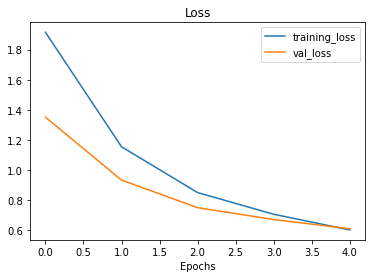

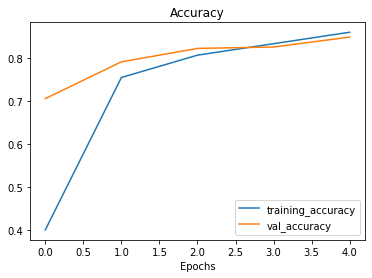

In [13]:
plot_loss_curves(history_model_0)

In [14]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.6096 - accuracy: 0.8404


[0.6096110343933105, 0.840399980545044]

In [15]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [16]:
# Summary of the base_model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [17]:
# Summary of our whole model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [18]:
# GlobalAveragePooling2D is transforming a 4d tensor into a 2d tensor

# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")
print("It removes the two inner-axis:es")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)
It removes the two inner-axis:es


In [19]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2]) # the same result as in the above cell

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### ⚒**Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D` and see what happens.

In [20]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_shape}\n")

# Pass the random tensor through a global max pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.MaxPooling2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the differet tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 (1, 4, 4, 3)

2D global max pooled random tensor:
 [[[[ 0.8504023  -0.40604794  0.3194337 ]
   [ 0.9058464   0.539707    1.6994323 ]]

  [[ 0.77852213  0.4012578   0.97772694]
   [ 0.32410017  1.1603122   0.52744764]]]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Max Pooled 2D tensor: (1, 2, 2, 3)


🔑**Note:** One of the reasons feature extractiontransfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers wich represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) wich can then be used to extract patterns out of for our own specific problem.

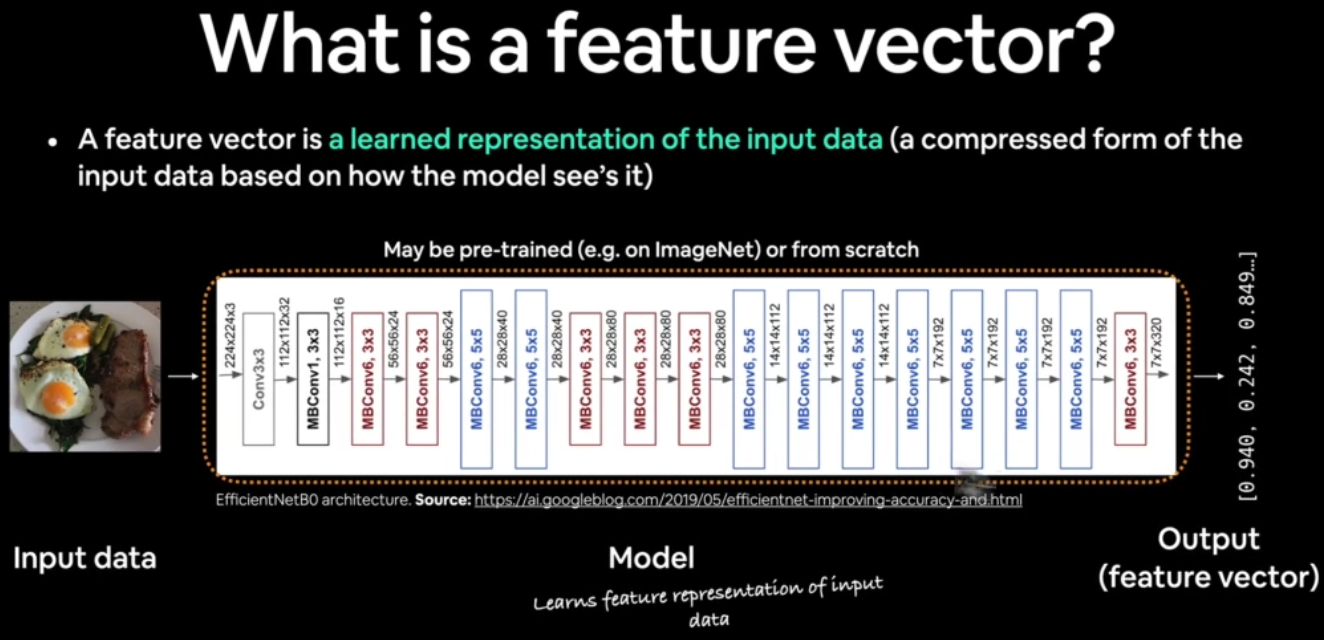

## Running a series of transfer learning exprimerients

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data? How about setting up a bunch of exeriments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning an 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model, this ensures consistency across evaluation metrics.

### Getting and preprocessing data for `model_1`

In [21]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-08-31 19:49:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   153MB/s    in 0.8s    

2022-08-31 19:49:30 (153 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [22]:
# Create training and test data
train_dir_1_percent= "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [23]:
# Inspect how many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [24]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation [documentation](https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers)

Benefits:
* Preprocessing (augmenting) happens on the GPU = faster.
* Image data augmentation only happens during training, allowing us to export the whole model and us it elsewhere.

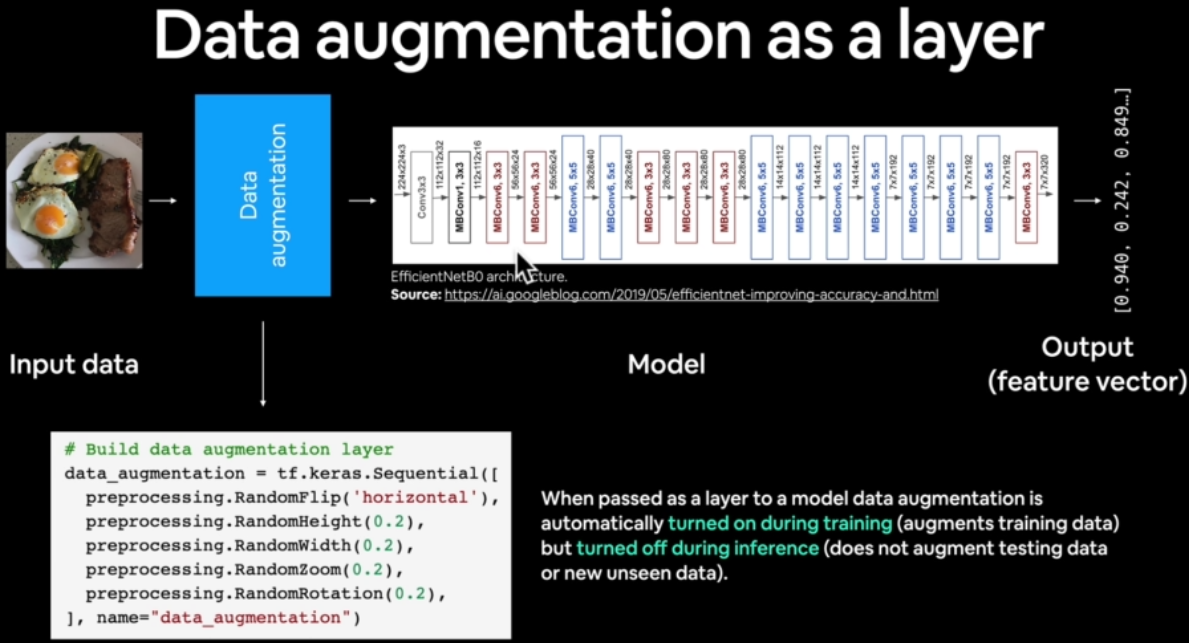

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficentNet's having rescaling built-in
], name="data_augmentation")

## Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 466.5, 347.5, -0.5)

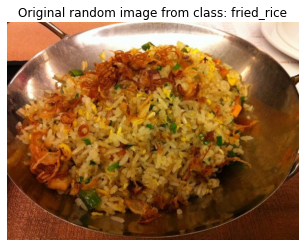

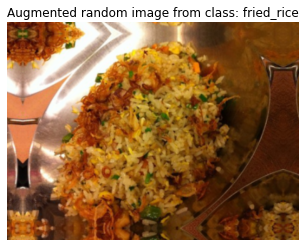

In [38]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Plot the augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)

In [29]:
train_data_1_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']